In [96]:
!pip install tabpfn shap eli5 lime torch torchvision torchaudio transformers datasets evaluate wandb mlflow optuna scikit-learn pandas numpy matplotlib seaborn plotly jupyterlab jupyterlab-git jupyterlab-lsp black jupyter-black autopep8 isort pylint flake8 pre-commit nbdev

# TabPFN Community installs optional functionalities around the TabPFN model
# These include post-hoc ensembles, interpretability tools, and more
!git clone https://github.com/PriorLabs/tabpfn-extensions
!pip install -e tabpfn-extensions[all]
!pip install -q huggingface_hub



  Using cached pyarrow-22.0.0-cp310-cp310-win_amd64.whl.metadata (3.3 kB)
Using cached pyarrow-22.0.0-cp310-cp310-win_amd64.whl (28.1 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 20.0.0
    Uninstalling pyarrow-20.0.0:
      Successfully uninstalled pyarrow-20.0.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-common 1.4.0 requires pyarrow<21.0.0,>=7.0.0, but you have pyarrow 22.0.0 which is incompatible.
fatal: destination path 'tabpfn-extensions' already exists and is not an empty directory.


Obtaining file:///C:/Users/Daryl/Documents/MAI/Year%201/SEM%202/MAI5200_Project/tabpfn-extensions
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Using cached pyarrow-20.0.0-cp310-cp310-win_amd64.whl.metadata (3.4 kB)
Using cached pyarrow-20.0.0-cp310-cp310-win_amd64.whl (25.8 MB)
  Building editable for tabpfn-extensions (pyproject.toml): started
  Building editable for tabpfn-extensions (pyproject.toml): finished with status 'done'
  Created wheel for tabpfn-extensions: filename=tabpfn_extensions-0.2.1-0.editable-py3-none-any.whl size=14295 s

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 20.0.0 which is incompatible.


In [97]:
import os
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import load_breast_cancer, load_diabetes, load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    roc_auc_score,
)

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, Markdown, Latex

# Baseline Imports
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import torch
from huggingface_hub import login

login()

from tabpfn import TabPFNClassifier, TabPFNRegressor

try:
  from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier, AutoTabPFNRegressor
except:
  raise SystemError('Please restart the session to fix this import.')


if not torch.cuda.is_available():
    raise SystemError('GPU device not found. For fast training, please enable GPU. See section above for instructions.')



In [98]:
ROOT = Path().resolve()
DATA_PATH = ROOT / "data-export.csv"
MODELS_DIR = ROOT / "models"
MODELS_DIR.mkdir(exist_ok=True)

print(f"Loading data from: {DATA_PATH}")
df = pd.read_csv(DATA_PATH, low_memory=False)
print(f"Initial Data shape: {df.shape}")

Loading data from: C:\Users\Daryl\Documents\MAI\Year 1\SEM 2\MAI5200_Project\data-export.csv
Initial Data shape: (4424, 37)


In [99]:
df.columns = [c.strip() for c in df.columns]

In [100]:
# Drop rows with missing target
if 'Target' not in df.columns:
    raise SystemExit("Target column not found in data")

print("Target value counts (including NaN):")
print(df['Target'].value_counts(dropna=False))

Target value counts (including NaN):
Target
NaN         1925
Graduate    1175
Dropout      892
Enrolled     432
Name: count, dtype: int64


In [101]:
# Simple preprocessing: convert all feature columns to numeric where possible
labeled_data = df.dropna(subset=["Target"])
unlabeled_data = df[df["Target"].isna()]


L = labeled_data.drop(columns=['Target']).copy()
U = unlabeled_data.drop(columns=['Target']).copy()

for col in L.columns:
    # Remove stray non-printable characters in column names if any
    try:
        L[col] = pd.to_numeric(L[col], errors='coerce')
    except Exception:
        L[col] = pd.to_numeric(L[col].astype(str).str.replace('\t','').str.strip(), errors='coerce')

for col in U.columns:
    # Remove stray non-printable characters in column names if any
    try:
        U[col] = pd.to_numeric(U[col], errors='coerce')
    except Exception:
        U[col] = pd.to_numeric(U[col].astype(str).str.replace('\t','').str.strip(), errors='coerce')


# Impute numeric missing with median
L = L.fillna(L.median())
U = U.fillna(U.median())

print(f"Labeled Data shape after preprocessing: {L.shape}")
print(f"Unlabeled Data shape after preprocessing: {U.shape}")

Labeled Data shape after preprocessing: (2499, 36)
Unlabeled Data shape after preprocessing: (1925, 36)


In [102]:
# Target encoding
y = labeled_data['Target'].astype(str).str.strip()
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Classes:", le.classes_)

Classes: ['Dropout' 'Enrolled' 'Graduate']


In [103]:
# Train/test split (stratify to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    L, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (1999, 36), Test shape: (500, 36)


In [104]:
# Random ForestModel
rendom_forest = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rendom_forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [105]:
# TabPFN Forest Model
tabpfn = TabPFNClassifier(random_state=42)
tabpfn.fit(X_train, y_train)

TabPFNClassifier(random_state=42)

In [108]:
# Random Forest Evaluation
rendom_forest_pred = rendom_forest.predict(X_test)
acc = accuracy_score(y_test, rendom_forest_pred)
report = classification_report(y_test, rendom_forest_pred, target_names=le.classes_, output_dict=True)
cm = confusion_matrix(y_test, rendom_forest_pred).tolist()

print(f"Accuracy: {acc:.4f}")
print("Classification report:")
print(classification_report(y_test, rendom_forest_pred, target_names=le.classes_))
print("Confusion matrix:")
print(cm)

Accuracy: 0.7600
Classification report:
              precision    recall  f1-score   support

     Dropout       0.83      0.79      0.81       179
    Enrolled       0.43      0.35      0.39        86
    Graduate       0.80      0.89      0.84       235

    accuracy                           0.76       500
   macro avg       0.69      0.68      0.68       500
weighted avg       0.75      0.76      0.75       500

Confusion matrix:
[[142, 17, 20], [24, 30, 32], [5, 22, 208]]


In [ ]:
# TabPFN Evaluation
tabpfn_pred = tabpfn.predict(X_test)
acc = accuracy_score(y_test, tabpfn_pred)
report = classification_report(y_test, tabpfn_pred, target_names=le.classes_, output_dict=True)
cm = confusion_matrix(y_test, tabpfn_pred).tolist()

print(f"Accuracy: {acc:.4f}")
print("Classification report:")
print(classification_report(y_test, tabpfn_pred, target_names=le.classes_))
print("Confusion matrix:")
print(cm)

Accuracy: 0.7900
Classification report:
              precision    recall  f1-score   support

     Dropout       0.85      0.82      0.83       179
    Enrolled       0.56      0.42      0.48        86
    Graduate       0.80      0.91      0.85       235

    accuracy                           0.79       500
   macro avg       0.74      0.71      0.72       500
weighted avg       0.78      0.79      0.78       500

Confusion matrix:
[[146, 11, 22], [20, 36, 30], [5, 17, 213]]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s finished


          Model  ROC AUC Mean  ROC AUC Std  \
0        TabPFN      0.887012     0.016426   
1  RandomForest      0.860370     0.013091   

                                              Scores  
0  [0.8987572032455144, 0.8952404641695799, 0.856...  
1  [0.8397813494484941, 0.874384815770601, 0.8594...  


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


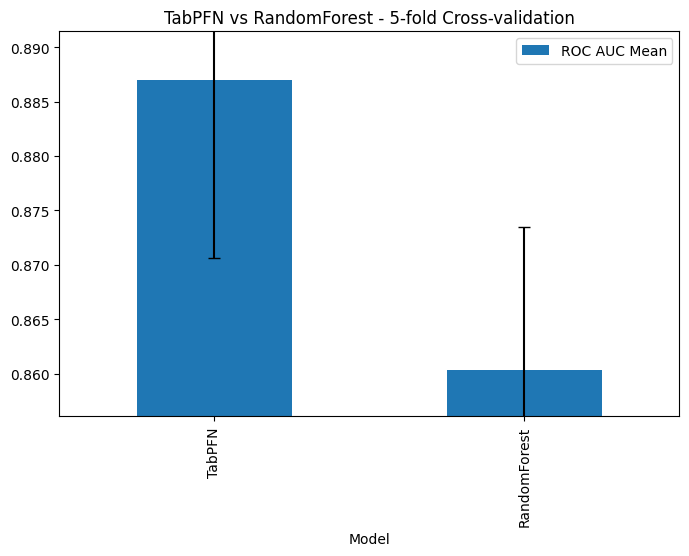

In [110]:
# Compare TabPFN and RandomForest using 5-fold cross-validation and capture all ROC AUC metrics
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

models = [
    ('TabPFN', tabpfn),
    ('RandomForest', rendom_forest)
]

scoring = 'roc_auc_ovr' if len(np.unique(y_test)) > 2 else 'roc_auc'
results = {}
for name, model in models:
    scores = cross_val_score(model, X_test, y_test, cv=5, scoring=scoring, n_jobs=1, verbose=1)
    results[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'all_scores': scores.tolist()
    }

results_df = pd.DataFrame([
    {'Model': name, 'ROC AUC Mean': res['mean'], 'ROC AUC Std': res['std'], 'Scores': res['all_scores']}
    for name, res in results.items()
])
print(results_df)

ax = results_df.plot(x='Model', y='ROC AUC Mean', kind='bar', figsize=(8, 5), yerr='ROC AUC Std', capsize=4)
ax.set_ylim(results_df['ROC AUC Mean'].min() * 0.995, min(1.0, results_df['ROC AUC Mean'].max() * 1.005))
ax.set_title('TabPFN vs RandomForest - 5-fold Cross-validation')
plt.show()

In [ ]:
# Predict on unlabeled data `U` using trained models and save results
# Align features, compute predictions and probabilities (where available), inverse-transform labels, and save CSV
import numpy as np
import pandas as pd
from IPython.display import display

if 'U' not in globals() or U is None or U.shape[0] == 0:
    print('No unlabeled data `U` available to predict on.')
else:
    # Prepare unlabeled features to match training columns
    X_unlabeled = U.copy()
    # Reindex to training columns (X_train) to ensure same order; fill missing columns with NaN
    X_unlabeled = X_unlabeled.reindex(columns=X_train.columns, copy=False)

    # Fill missing values using training medians (safe imputation)
    try:
        train_median = X_train.median()
        X_unlabeled = X_unlabeled.fillna(train_median)
    except Exception:
        X_unlabeled = X_unlabeled.fillna(0)

    predictions_list = []

    models_for_pred = [
        ('RandomForest', rendom_forest),
        ('TabPFN', tabpfn)
    ]

    for name, model in models_for_pred:
        out = X_unlabeled.reset_index(drop=True).copy()
        # Attempt to get probabilities
        probs_df = None
        try:
            proba = model.predict_proba(X_unlabeled)
            # If multiclass, columns correspond to le.classes_
            if proba.ndim == 2 and proba.shape[1] == len(le.classes_):
                probs_df = pd.DataFrame(proba, columns=[f'prob_{c}' for c in le.classes_])
            else:
                # fallback generic columns
                probs_df = pd.DataFrame(proba, columns=[f'prob_{i}' for i in range(proba.shape[1])])
        except Exception:
            probs_df = None

        # Predictions: try to inverse transform if needed
        try:
            pred_idx = model.predict(X_unlabeled)
            try:
                pred_labels = le.inverse_transform(pred_idx)
            except Exception:
                # If inverse_transform fails, try mapping numeric to string
                pred_labels = pred_idx
        except Exception as e:
            raise RuntimeError(f'Failed to predict with model {name}: {e}')

        out[f'{name}_prediction'] = pred_labels
        if probs_df is not None:
            for col in probs_df.columns:
                out[f'{name}_{col}'] = probs_df[col].values

        predictions_list.append((name, out))

    # Combine predictions side-by-side (merge on index)
    final = X_unlabeled.reset_index(drop=True).copy()
    for name, df_out in predictions_list:
        # take only prediction and prob columns from df_out
        cols = [c for c in df_out.columns if c.endswith('_prediction') or c.startswith(f'{name}_prob')]
        final = pd.concat([final, df_out[cols].reset_index(drop=True)], axis=1)

    # Save results
    out_path = MODELS_DIR / 'unlabeled_predictions.csv'
    final.to_csv(out_path, index=False)
    print(f'Saved unlabeled predictions to: {out_path}')
    display(final.head())
